In [1]:
setwd('..')

## Daily Cases by Colorado County

In [2]:
# helper functions for computing LQ and rates
source('code/support_functions.R')

In [3]:
## fetch any new case files
# will skip download if no new files are available
source('code/get_new_case_data.R')

Using an auto-discovered, cached token.
To suppress this message, modify your code or options to clearly consent to the use of a cached token.
See gargle's "Non-interactive auth" vignette for more details:
https://gargle.r-lib.org/articles/non-interactive-auth.html
The googledrive package is using a cached token for jotu9073@colorado.edu.


No new case data files available.



County population counts are also based on ACS 5-year estimates for 2018 and were acquired from the [Social Explorer Database](https://socialexplorer.com).

In [4]:
## prep total population data
# county population (sex by age, aggregates to total county pop)
co_sxa <- read.csv('data/co_sex_by_age_by_county_acs_2018_5yr.csv',
                   stringsAsFactors = F) 

# subset the county ID and total population columns
co_pop <- co_sxa[,c('Geo_NAME', 'ACS18_5yr_B01001001')]

# rename total population column
names(co_pop)[2] <- 'pop'

In [5]:
# some of the earlier dates don't have the ` County` suffix,
# so remove this from the total population count IDs
co_pop$Geo_NAME <- gsub(' County', '', co_pop$Geo_NAME)

In [6]:
# all filenames in the `data` folder
data_files <- list.files('data')

In [7]:
# filenames for all covid19 case data files
covid_sf <- data_files[startsWith(data_files, 'covid19')]

In [8]:
## build daily case data
daily_cases_cty <- lapply(covid_sf, function(covx){
    
    # full path to the file
    path.covx <- file.path('data', covx)
    
    # extract date info from filename
    date.covx <- gsub('covid19_case_summary_', '', covx) # strip prefix
    date.covx <- gsub('.csv', '', date.covx) # strip file extension
    
    # read in file
    data.covx <- read.csv(path.covx, stringsAsFactors = F)
    
    # subset to counties
    cty.covx <- data.covx[data.covx$description == 'Case Counts by County' & data.covx$metric == 'Cases',] 
    
    # append date 
    cty.covx <- data.frame(date = date.covx, cty.covx, stringsAsFactors = F)
    
    # convert date from text to date/time
    cty.covx$date <- lubridate::date(cty.covx$date)
    
    # ensure `value` column is numeric
    cty.covx$value <- as.numeric(cty.covx$value)
    
    # strip `County` prefix if it exists 
    cty.covx$attribute <- gsub(' County', '', cty.covx$attribute)
    
    # append total population counts
    cty.covx <- merge(cty.covx, co_pop, by.x = 'attribute', by.y = 'Geo_NAME')
    
    # append location quotient and case rates
    cty.covx$lq <- lq(cty.covx)
    cty.covx$cases_100k <- rate(cty.covx)
    
    cty.covx[,c('attribute', 'date', 'value', 'pop', 'lq', 'cases_100k')]
    
})

In [9]:
# combine results into a single data frame
daily_cases_cty <- do.call(rbind, daily_cases_cty)

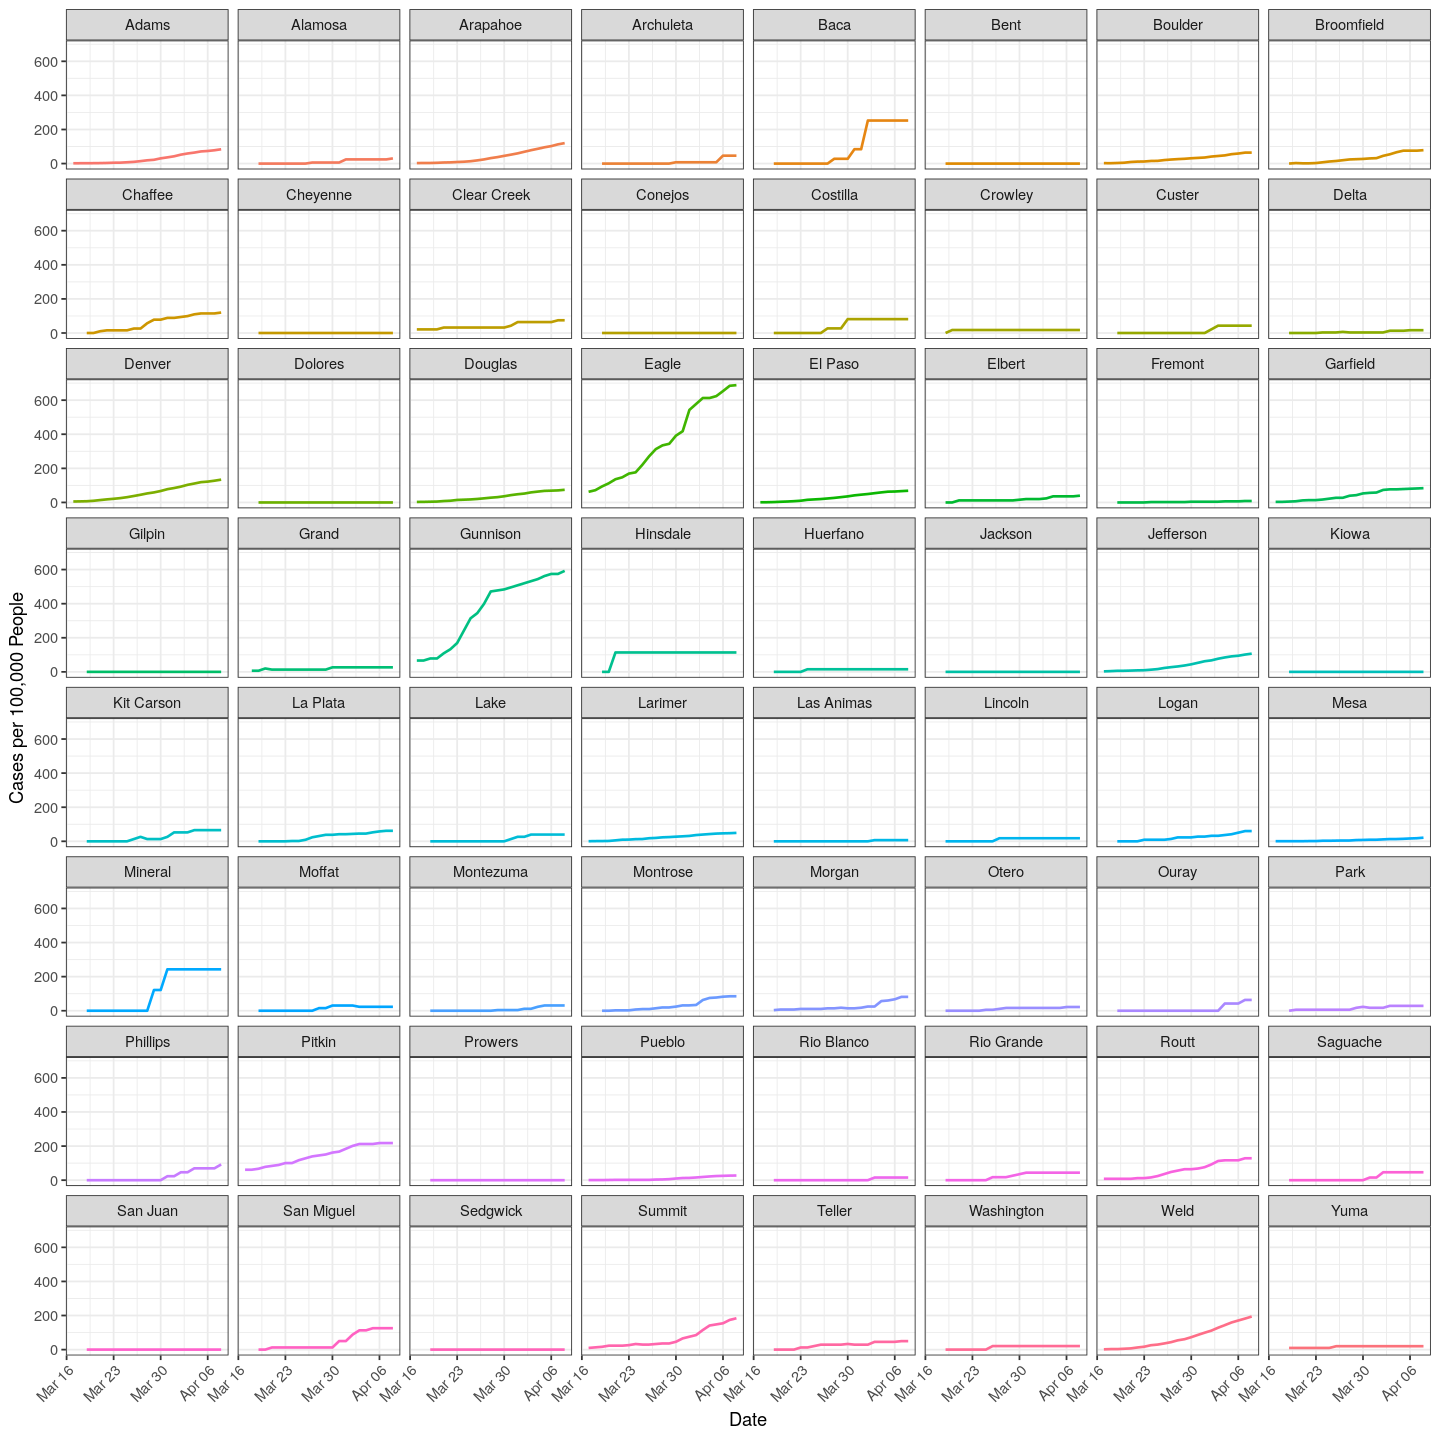

In [10]:
# plot results
library(ggplot2)
options(repr.plot.height = 12, repr.plot.width = 12)
ggplot(data = daily_cases_cty, aes(x = date, y = cases_100k, color = attribute)) + 
    geom_line(size = 0.75) +
    facet_wrap(~attribute) +
    xlab('Date') +
    ylab('Cases per 100,000 People') +
    theme_bw() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    theme(legend.position = 'none')

Warning message:
“Transformation introduced infinite values in continuous y-axis”


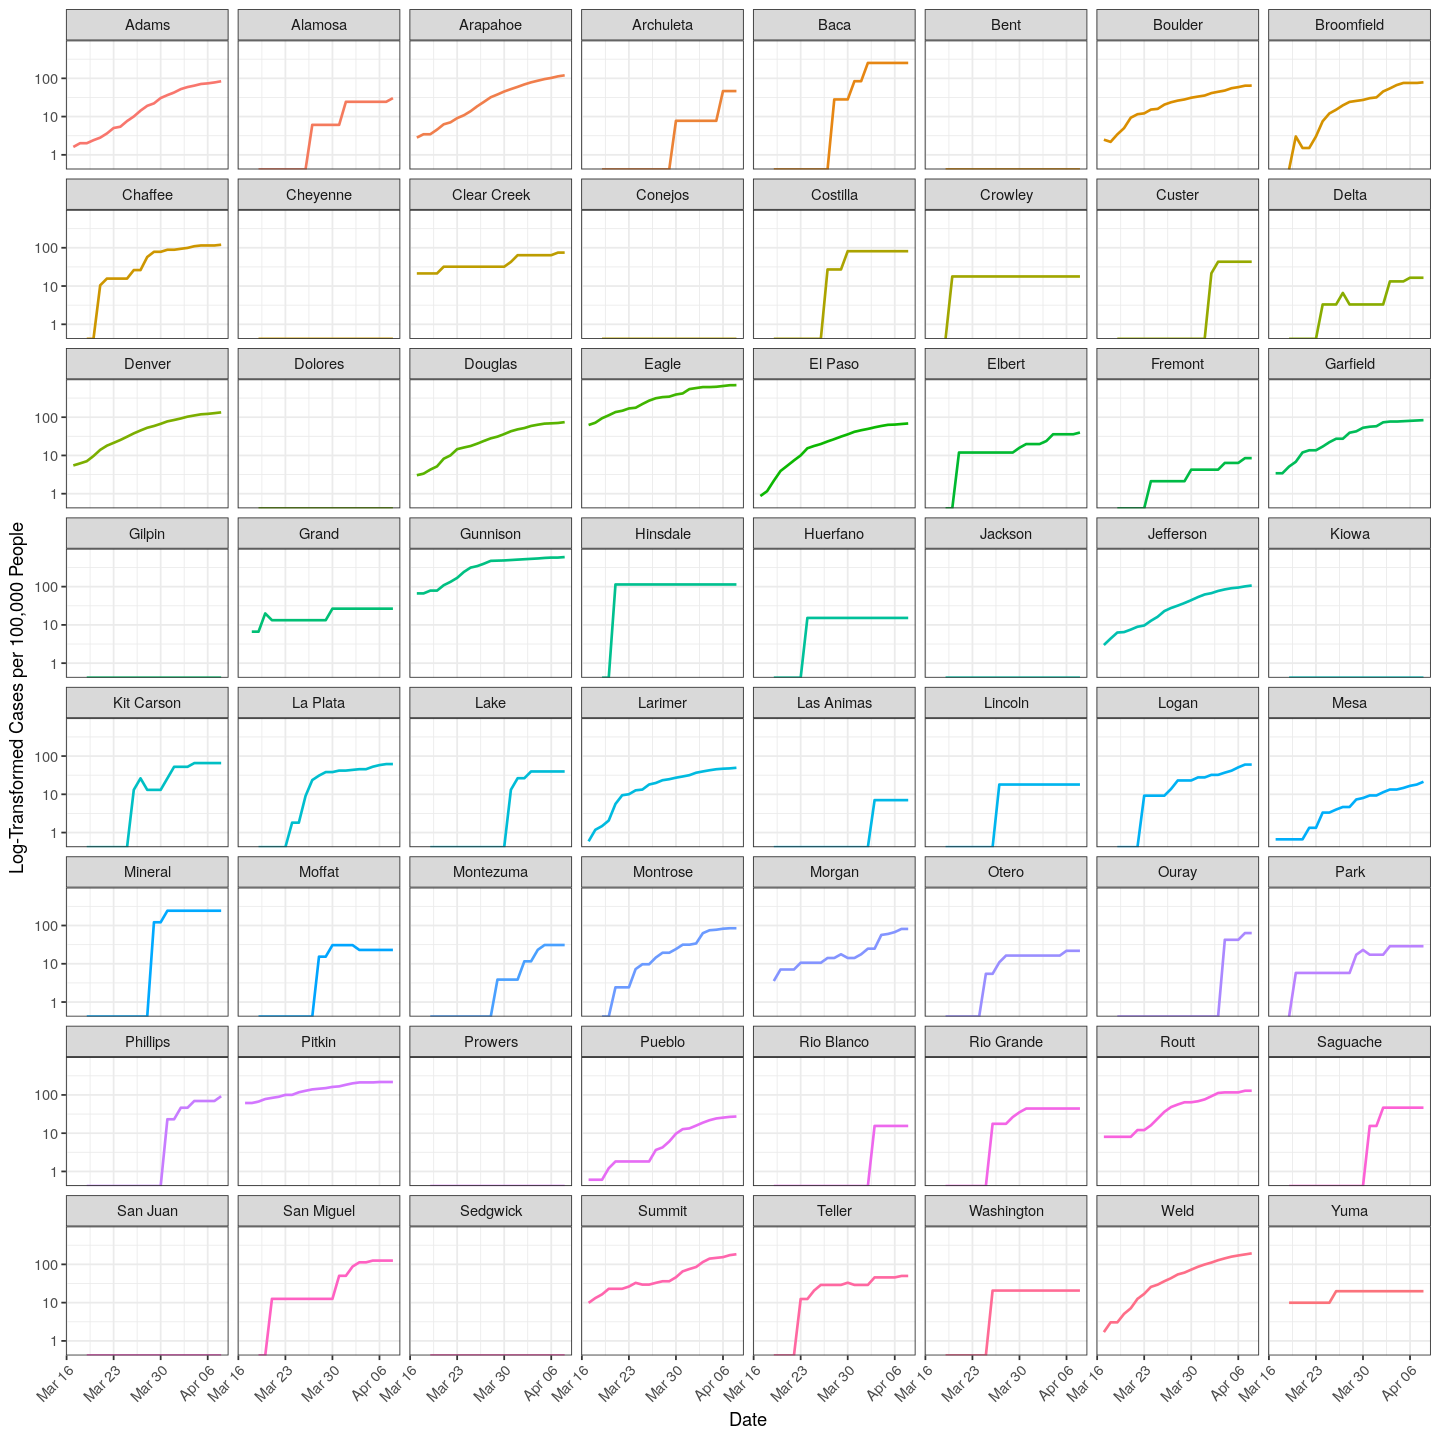

In [11]:
# with logarithmic y-axis
options(repr.plot.height = 12, repr.plot.width = 12)
ggplot(data = daily_cases_cty, aes(x = date, y = cases_100k, color = attribute)) + 
    geom_line(size = 0.75) +
    facet_wrap(~attribute) +
    scale_y_log10() +
    xlab('Date') +
    ylab('Log-Transformed Cases per 100,000 People') +
    theme_bw() +
    theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
    theme(legend.position = 'none')

## County Confirmed Case Trajectories (Experimental)

**Methodology** 

- Use Affinity Propagation clustering to group daily reports of confirmed cases by county based on two criteria:
    1. The current rate of confirmed cases per 100,000 people.
    2. The change in confirmed cases per 100,000 people since the previous day.
    
- March 20, 2020 is used as the intial date, since it is the first day at which the change in cases/100k people by county can be measured (3/19/2020 marks the first day in which all counties were reporting).  

- From the ensemble of daily clusterings, measure the percentage of days to date that any two counties shared a cluster label.

- Perform a final clustering (also using Affinity Propagation) to group the change trajectories from 3/20/2020 to present.

In [12]:
# convert daily cases back to list format
daily_cases_split <- split(daily_cases_cty, daily_cases_cty$date)

In [13]:
# build cluster ensemble
library(apcluster)
source('code/apcluster_helper.R')
ens <- sapply(4:length(daily_cases_split), function(i){
    
    day1 <- daily_cases_split[[i-1]]
    day2 <- daily_cases_split[[i]]
    
    rate_of_change <- (day2$cases_100k - day1$cases_100k)
    rate_of_change[is.na(rate_of_change)] <- 0
    
    inx <- scale(cbind(rate_of_change, day2$cases_100k))
    rownames(inx) <- day2$attribute
    
    set.seed(909)
    apcx <- apcluster(negDistMat(inx))
    
    clustx <- clust_vec(apcx)
    names(clustx) <- rownames(inx)
    clustx
    
})


Attaching package: ‘apcluster’


The following object is masked from ‘package:stats’:

    heatmap




In [14]:
# convert labels to binary format
ed <- lapply(1:ncol(ens), function(i){
    
    indmat <- model.matrix(~factor(ens[,i])-1)
    colnames(indmat) <- paste0(paste0('d', i), letters[1:ncol(indmat)])
    rownames(indmat) <- rownames(ens)
    as.matrix(vegan::vegdist(indmat, method = 'jaccard'))
    
})
# ens_mm <- do.call(cbind, ens_mm)
ed <- Reduce(ed, f = '+')

In [15]:
## build similarity matrix 
# similarity as percentage of times two counties co-clustered
es <- 1 - ed

In [16]:
set.seed(909)
apce <- apcluster(es)

In [17]:
apce


APResult object

Number of samples     =  64 
Number of iterations  =  214 
Input preference      =  -17 
Sum of similarities   =  -328 
Sum of preferences    =  -187 
Net similarity        =  -515 
Number of clusters    =  11 

Exemplars:
   Costilla Denver Dolores Eagle El Paso Gunnison Lincoln Logan Pitkin Saguache 
   Yuma
Clusters:
   Cluster 1, exemplar Costilla:
      Baca Clear Creek Costilla Hinsdale Kit Carson
   Cluster 2, exemplar Denver:
      Chaffee Denver Routt Summit Weld
   Cluster 3, exemplar Dolores:
      Archuleta Bent Cheyenne Conejos Delta Dolores Fremont Gilpin Jackson 
      Kiowa Las Animas Montezuma Ouray Prowers Rio Blanco San Juan Sedgwick
   Cluster 4, exemplar Eagle:
      Eagle
   Cluster 5, exemplar El Paso:
      Adams Arapahoe Boulder Douglas El Paso Garfield Jefferson Larimer
   Cluster 6, exemplar Gunnison:
      Gunnison
   Cluster 7, exemplar Lincoln:
      Alamosa Huerfano Lincoln Mesa Moffat Otero Park Pueblo Washington
   Cluster 8, exemplar 

In [18]:
# load county boundaries
library(sf)
counties <- read_sf('data', 'cb_2018_us_county_500k')
counties <- counties[counties$STATEFP == '08',]
counties <- counties[match(rownames(es), counties$NAME),]

Linking to GEOS 3.5.1, GDAL 2.1.2, PROJ 4.9.3



In [19]:
# assign cluster labels
counties['cluster'] <- factor(clust_vec(apce))

In [20]:
daily_cases_cty$cluster <- counties$cluster[match(daily_cases_cty$attribute, counties$NAME)]

In [21]:
## map plot
mapplot <- ggplot(data = counties, aes(fill = cluster)) + 
            geom_sf(size = 0.25) +
            scale_fill_brewer(type = 'qual', palette = 'Set3') +
            ggtitle(label = 'Colorado COVID-19 Daily Confirmed Case Trajectories',
                   subtitle = paste0('(', '2020-03-20 - ', Sys.Date(), ')')) +
            theme_void() +
            theme(plot.title = element_text(hjust = 0.5), 
                  plot.subtitle = element_text(hjust = 0.5), 
                  legend.position = 'none')

In [22]:
## change trajectories by cluster
# untransformed y-axis
trjplot <- ggplot(data = daily_cases_cty[daily_cases_cty$date >= '2020-03-20',],
                  aes(x = date, y = cases_100k, fill = cluster)) + 
                geom_smooth(color = 'black', size = 0.25) +
                scale_fill_brewer(type = 'qual', palette = 'Set3') +
                facet_wrap(~cluster, scales = 'free_y') +
                scale_y_log10() +
                xlab('Date') +
                ylab('Cases per 100,000 People') +
                geom_vline(xintercept = 4) +
                theme_bw() +
                theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
                theme(legend.position = 'none')

In [23]:
## change trajectories by cluster
# with logarithmic y-axis
trjplot_log <- ggplot(data = daily_cases_cty[daily_cases_cty$date >= '2020-03-20',],
                  aes(x = date, y = cases_100k, fill = cluster)) + 
                geom_smooth(color = 'black', size = 0.25) +
                scale_fill_brewer(type = 'qual', palette = 'Set3') +
                facet_wrap(~cluster) +
                scale_y_log10() +
                xlab('Date') +
                ylab('Log-Transformed Cases per 100,000 People') +
                geom_vline(xintercept = 4) +
                theme_bw() +
                theme(axis.text.x = element_text(hjust = 1, angle = 45)) +
                theme(legend.position = 'none')

#### Raw cases/1000 by cluster with variable y-axes

Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 404 rows containing non-finite values (stat_smooth).”


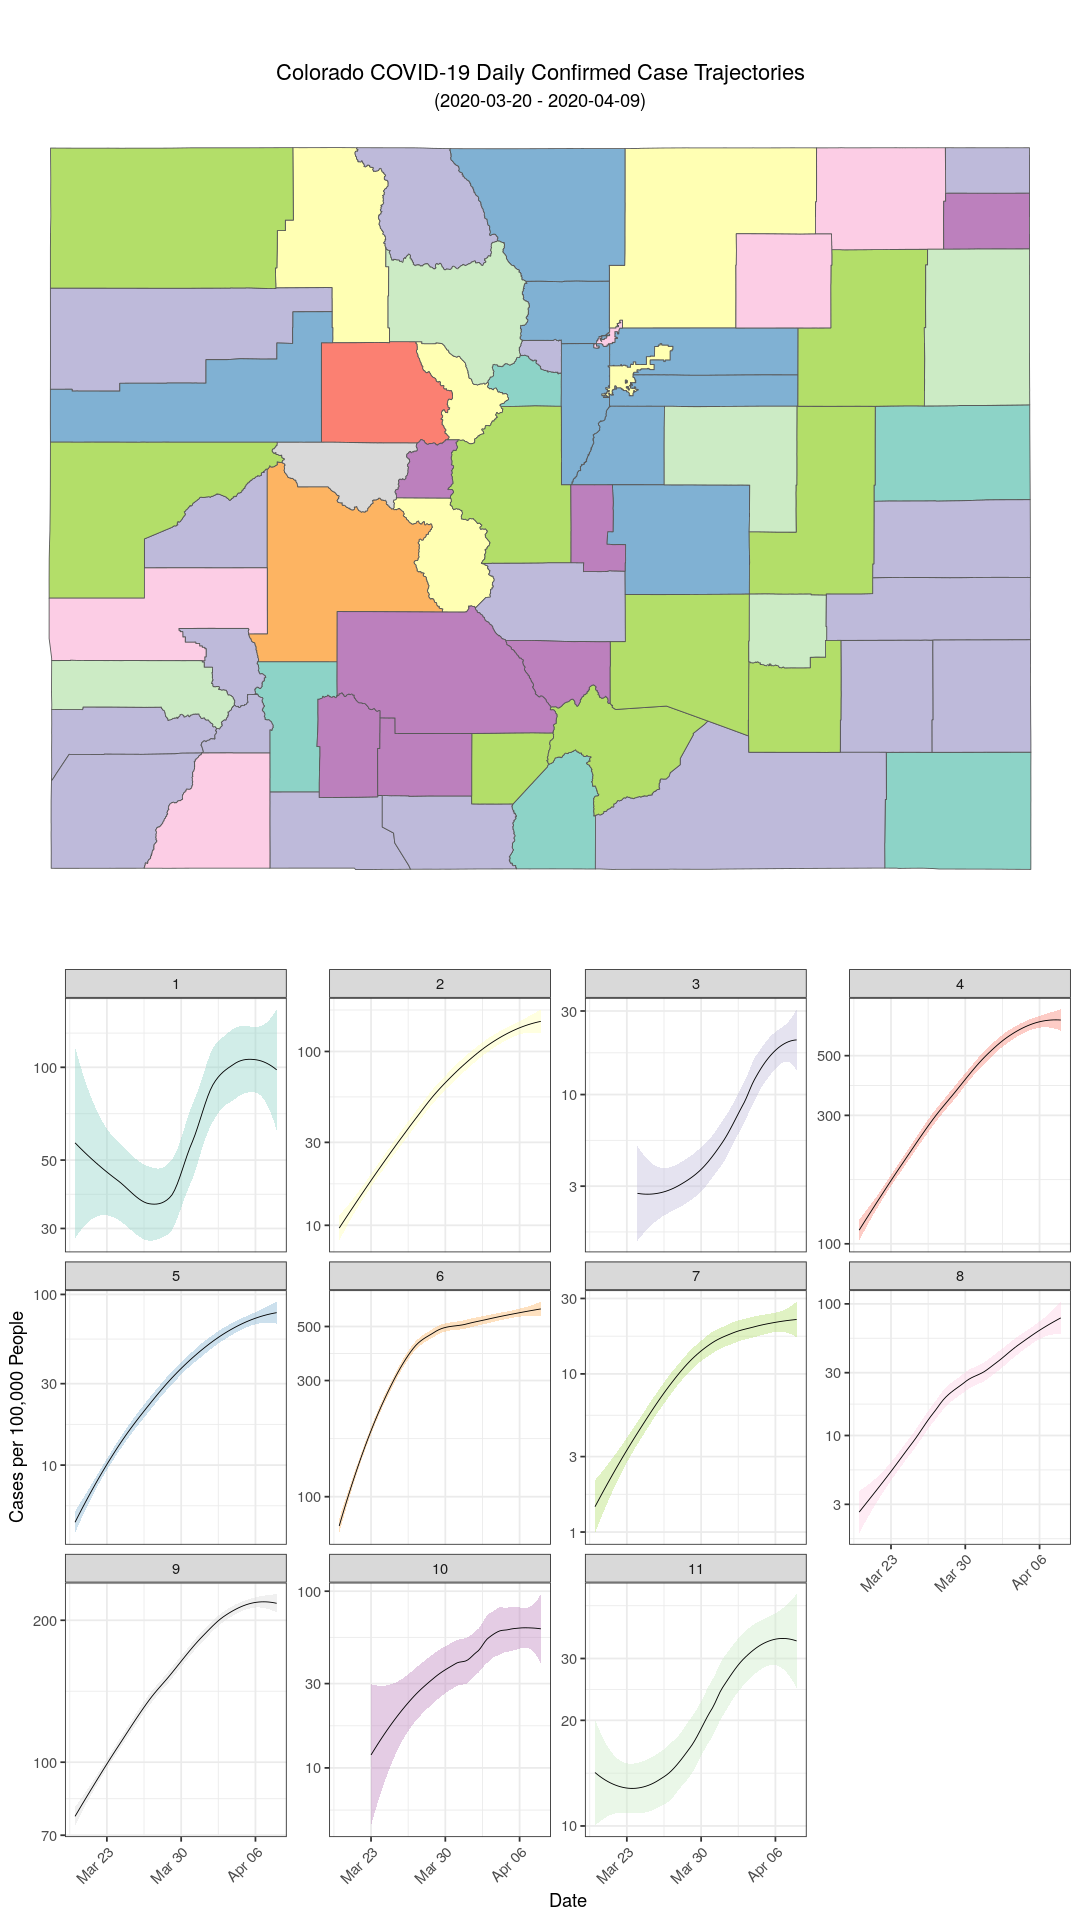

In [24]:
options(repr.plot.height = 16, repr.plot.width = 9)
cowplot::plot_grid(mapplot, trjplot, ncol = 1)

#### Log-transformed cases/1000 by cluster with fixed y-axes

Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 404 rows containing non-finite values (stat_smooth).”


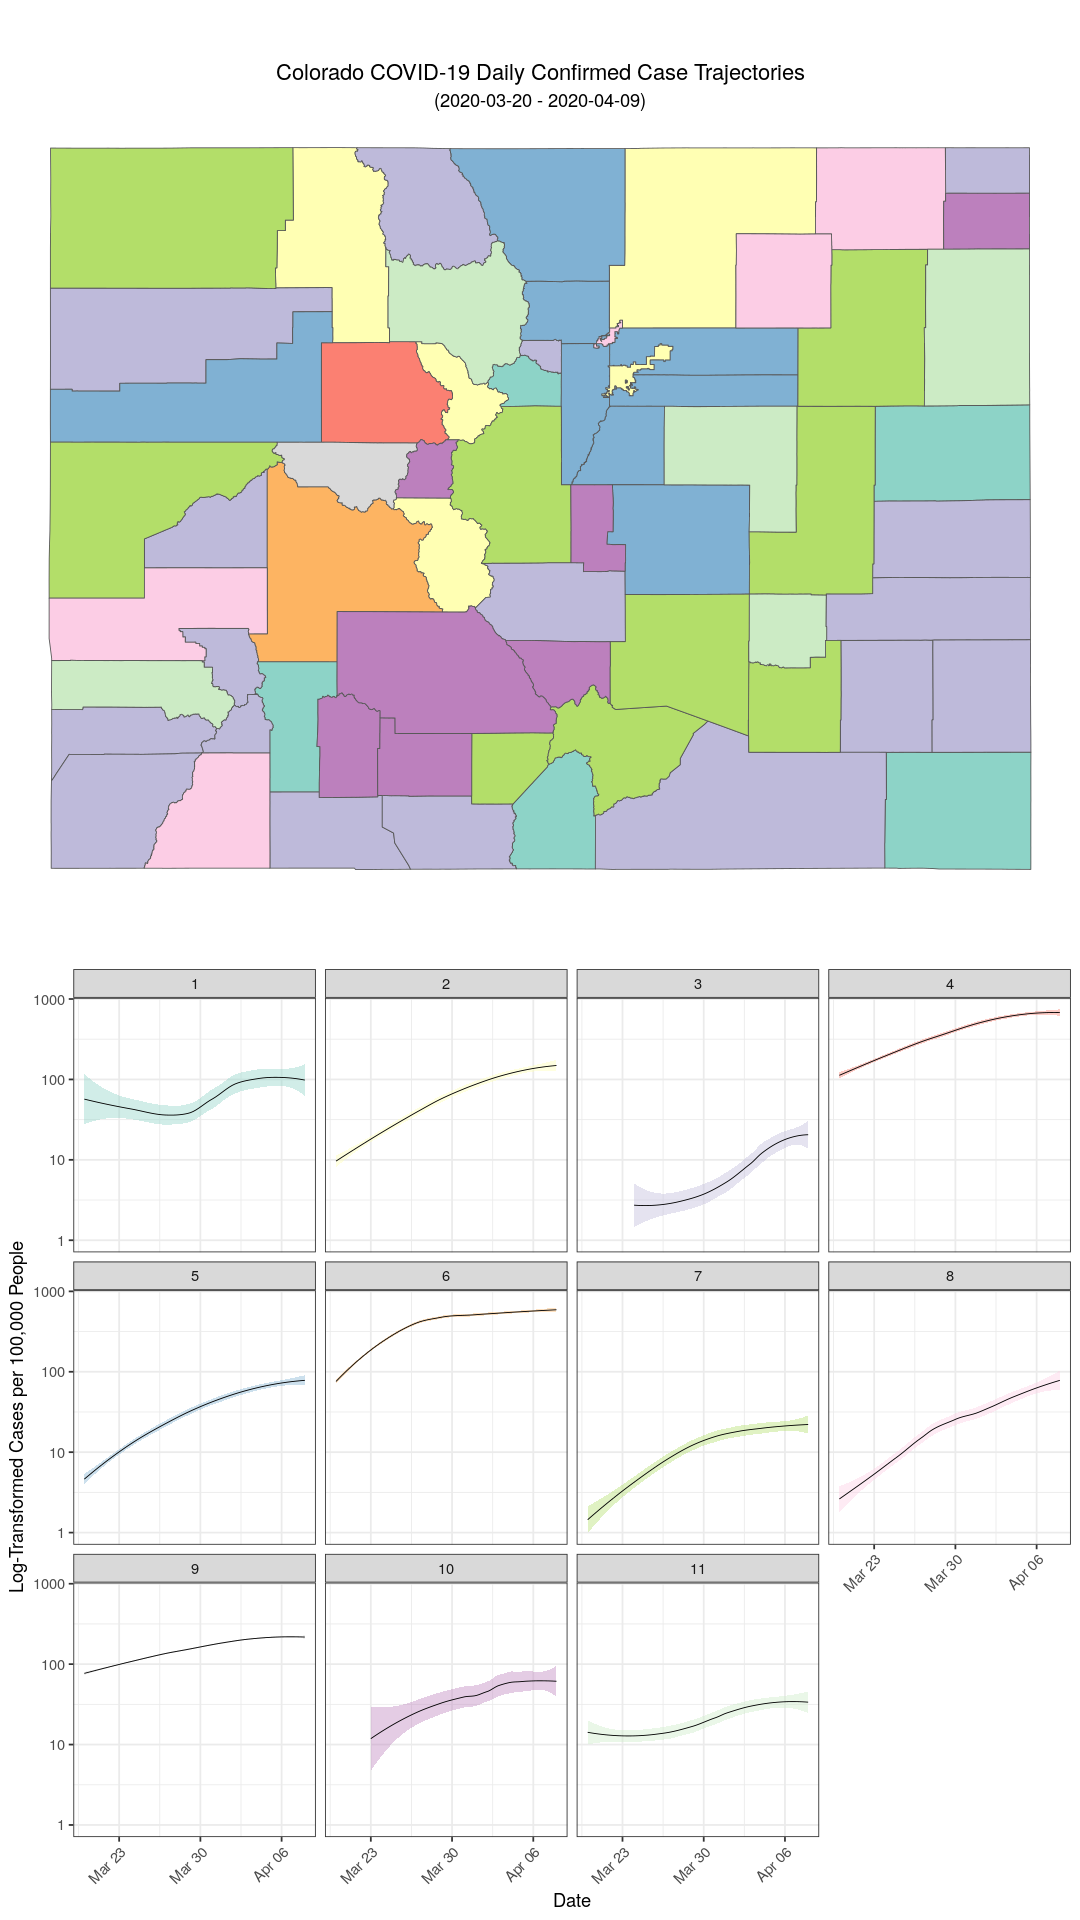

In [25]:
options(repr.plot.height = 16, repr.plot.width = 9)
cowplot::plot_grid(mapplot, trjplot_log, ncol = 1)